# Bank Customer Churn

## Introduction
The project utilized a dataset sourced from Kaggle (https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset) containing information about customers of a specific bank. The objective is to address the issue of bank customer turnover, which can be determined using the "Exited" column in the dataset. This column indicates whether or not a customer has churned. Therefore, the task at hand is to develop a classification model that predicts whether a customer will cancel their bank account or not.

However, before delving into the implementation of a binary classification algorithm, it is important to establish some business assumptions and reasoning about churn. This will enable us to comprehend the features that characterize customers who are considered as churned by the bank as we progress with the project.

To begin with, let's discuss the project's objective, the problem we aim to address, and the expected outcome 
From the bank's perspective, understanding the customer profile is crucial in making decisions such as offering specific services, increasing credit limit, or determining if a customer is likely to leave the bank.

Since the dataset already tells us whether customer x is churn or not, our task is to draw this profile and predict that, given these characteristics that customer has, it is likely that he will be Churn, so the bank can take measures to retain these customers.

## Assumptions

    1- Customers may cancel their bank account for a variety of reasons, including dissatisfaction with banking services, changing financial circumstances or transferring to another bank.

    2- The dataset contains information about customers such as age, gender, geographic location, bank transaction history, length of bank association, account type, and other variables.

    3- Customer information was collected over time, allowing the model to identify patterns and trends that can predict the likelihood of churn.

    4- Customers who did not carry out transactions within a period of 3 months were considered churn.

    5- The model must be able to distinguish between customers who are more likely to cancel their accounts and those who are less likely to do so, so that the bank can take steps to retain at-risk customers.



# 0.0 Imports

In [ ]:
import inflection
import warnings

import pandas     as pd
import numpy      as np
import seaborn    as sns
import xgboost    as xgb
import tensorflow as tf

from matplotlib              import pyplot as plt
from scipy                   import stats  as ss
from PIL                     import Image 
from tensorflow              import keras
from keras.layers            import Activation, Dense
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.datasets        import make_classification
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import roc_auc_score, roc_curve, classification_report, confusion_matrix, auc, accuracy_score
from sklearn.neighbors       import KNeighborsClassifier 
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from lightgbm                import LGBMClassifier

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = [12,6]
warnings.filterwarnings( 'ignore' )
sns.set()

## 0.1 Auxiliary Functions

In [3]:
def summary(data):
    data = data.select_dtypes(include=['int64','float64'])
    d_min = pd.DataFrame(data.apply(min)).T
    d_max = pd.DataFrame(data.apply(max)).T
    d_range = pd.DataFrame(data.apply(lambda x: x.max() - x.min())).T
    d_mean = pd.DataFrame(data.apply(np.mean)).T
    d_median = pd.DataFrame(data.apply(np.median)).T
    d_std = pd.DataFrame(data.apply(np.std)).T
    d_skew = pd.DataFrame(data.apply(lambda x: x.skew())).T
    d_kurt = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T

    df = pd.concat([d_min,d_max,d_range,d_mean,d_median,d_std,d_skew,d_kurt]).T
    df.columns = ['Min','Max','Range','Mean','Median','Standard Deviation','Skewness','Kurtosis']
    return df
    
def cramer_v( x, y ):
    cm = np.matrix(pd.crosstab( x, y ))
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
    
def norm(var):
    var_median = np.median(var)
    interquantile_range = var.quantile(0.75) - var.quantile(0.25)
    
    z = (var - var_median) / interquantile_range
    return round(z, 3)

def cm_plot(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)

    group_names = ['True No-Churn','False Churn','False No-Churn','True Churn']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');


# 1.0 Preprocessing


In [4]:
#reading dataset
data = pd.read_csv('churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## 1.1 Rename Columns

In [5]:
#Renaming as snake case
cols_camelcase = list(data.columns)
snake_case = lambda x: inflection.underscore(x)
cols_snake_case = list(map(snake_case,cols_camelcase))
data.columns = cols_snake_case
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.2 Data Dimensions

In [6]:
print(f'The number of rows is: {data.shape[0]}')
print(f'The number of columns is: {data.shape[1]}')

The number of rows is: 10000
The number of columns is: 14


In [7]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Variables:

    - Inputs:
    1- customer_id: Unique account number assigned to each customer.
    2- surname: Family name or last name of the customer.       
    3- credit_score: Numeric score indicating the creditworthiness of the customer.
    4- geography: Country of residence of the customer.
    5- gender: Gender of the customer.
    6- age: Age of the customer in years.
    7- tenure: Length of time (in years) the customer has held an account with the bank.
    8- balance: Current balance of the customer's account.
    9- num_of_products: Number of products (e.g. savings, loan, insurance) that the customer has with the bank.
    10- has_cr_card: Whether the customer has a credit card or not.
    11- is_active_member: Whether the customer is currently an active member of the bank or not.
    12- estimated_salary: Estimated annual salary of the customer.

    - Output:    
    1- exited: If is Churn or not

In total, are 10.000 observartions and 13 variables (in dataset there is 'row_number' that is some autoincrement ID, it can be dropped)

In [8]:
# dropping 'row_number' 
data = data.drop('row_number', axis=1)

In [9]:
#verifying churn rate
no_churn_p = len(data[data['exited']==0])/len(data)
print(f'% of no Churn is: {1-no_churn_p}')
print(f'% of Churn is: {no_churn_p}')

% of no Churn is: 0.2037
% of Churn is: 0.7963


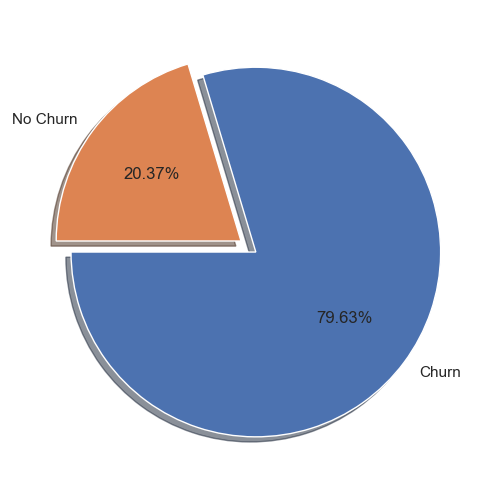

In [10]:
no_churn_p = len(data[data['exited'] == 1])/len(data)
x = [1-no_churn_p,no_churn_p]
plt.pie(x, explode = [0.1,0.0], labels = ['Churn', 'No Churn'], shadow = True, startangle=180,autopct='%1.2f%%');

About 20% of the individuals in dataset are churns. Although our data set is unbalanced, we will proceed with the analysis of the churn problem and evaluate the performance of our models. If we find that the model's performance is not satisfactory, we will consider using balancing techniques to improve the results.

## 1.3 Data types

In [11]:
data.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA and Duplicated

In [12]:
data.isna().sum() #NA

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [13]:
data.duplicated().sum() #Verify if are duplicated rows

0

In [14]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            10000 non-null  int64  
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


We can see that there are no duplicated rows or missing values in the dataset, and all variables have the correct data type.

## 1.5 Descriptive Statistics

### 1.5.1 Numeric

In [15]:
summary(data.drop('customer_id', axis=1))

,Min,Max,Range,Mean,Median,Standard Deviation,Skewness,Kurtosis
credit_score,350.000,850.000,500.000,650.529,652.000,96.648,-0.072,-0.426
age,18.000,92.000,74.000,38.922,37.000,10.487,1.011,1.395
tenure,0.000,10.000,10.000,5.013,5.000,2.892,0.011,-1.165
balance,0.000,250898.090,250898.090,76485.889,97198.540,62394.285,-0.141,-1.489
num_of_products,1.000,4.000,3.000,1.530,1.000,0.582,0.746,0.583
has_cr_card,0.000,1.000,1.000,0.706,1.000,0.456,-0.902,-1.187
is_active_member,0.000,1.000,1.000,0.515,1.000,0.500,-0.060,-1.997
estimated_salary,11.580,199992.480,199980.900,100090.240,100193.915,57507.617,0.002,-1.182
exited,0.000,1.000,1.000,0.204,0.000,0.403,1.472,0.166


With summary function, created in section 0.1 Auxiliary Functions, we'he an overview about variables statistics. We have observed that for most of the variables, the centrality measures (mean, median) converge, and the minimum and maximum values do not indicate any extreme or outlier values. The measures of asymmetry and kurtosis provide us with a preliminary idea of the shape of the density curve, but we will need to further explore this with visual aids.

However, we have noticed that the variables 'balance' and 'estimated_salary' exhibit a high level of variability, with the mean distorting the median and the standard deviation values being proportionally high in comparison to the other variables. We need to keep this in mind as we explore the data and draw insights, and we should consider appropriate techniques to handle these variables.

### 1.5.2 Categoric



In [16]:
#Categoric
cat = data.select_dtypes(include='object')

#Levels
print(cat.apply(lambda x: x.unique().shape[0])) #data.describe(include='object')

surname      2932
geography       3
gender          2
dtype: int64


We have identified that the categorical variables in our dataset are the customer's name, the country of residence, and gender. As the customer's name is unlikely to be useful for our project, we can safely discard it.

On closer examination, we can also consider the variables 'has_cr_card' and 'is_active_member' as categorical variables, as they can be interpreted as binary (yes/no) responses. Therefore, we can conduct a categorical analysis of these variables as well.

In [17]:
# Dropping surname
data = data.drop('surname', axis=1)

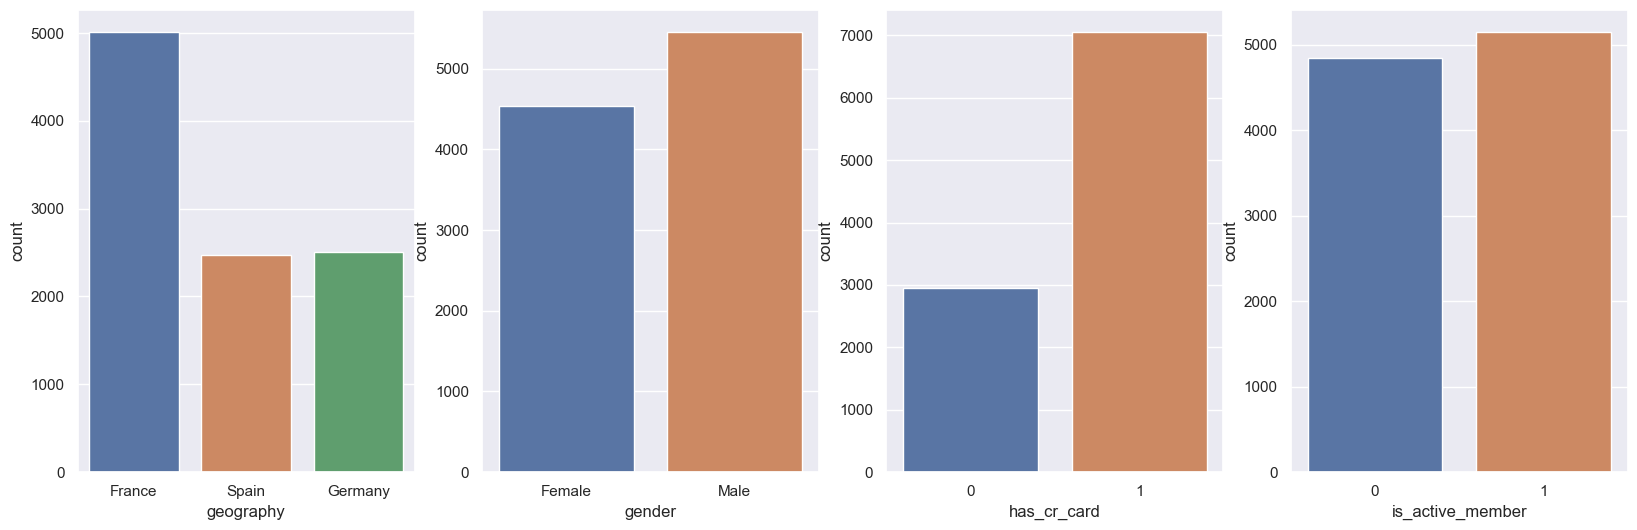

In [18]:
#Plots
plt.rcParams['figure.figsize'] = [20,6]
plt.subplot(1,4,1)
sns.countplot(data['geography'])

plt.subplot(1,4,2)
sns.countplot(data['gender'])

plt.subplot(1,4,3)
sns.countplot(data['has_cr_card'])

plt.subplot(1,4,4)
sns.countplot(data['is_active_member']);

Through the plots, we can visualize the frequency of observations for each variable. We can observe that the majority of clients are from France, which may indicate that the bank primarily operates in this region. The number of male and female clients is almost equal, indicating a balanced gender distribution among the clients.

The proportion of active and inactive members is also well balanced, perhaps an insight for the bank to adopt more loyalty measures for these customers in order to reduce the number of inactive members.

However, there is an unbalance between the number of customers who have a credit card and those who do not, which may be due to the bank's strategy of retaining good customers, making it reliable to offer credit. We will investigate this further to determine if this unbalance needs to be addressed.

# 2.0 Exploratory Data Analysis

From here, we'll rename the 'exited' variable to 'churn' .

In [19]:
data = data.rename(columns={'exited':'churn'})
df2 = data.copy()
df2.head(2)

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,15647311,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0


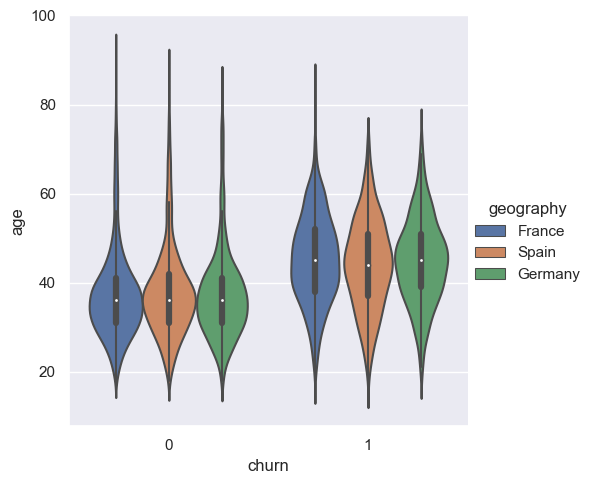

In [20]:
#relationship between a numerical and categorical
sns.catplot(data=df2, x="churn",y= "age", hue = 'geography',kind="violin");

Similar to the boxplot, the violin plot provides summary statistics about the variables and also displays information about the density of the distribution. We observed that the behavior of customers, both those who churn and those who do not, is similar across all three countries. Density shows that the median of the boxplot is representing the dispersion of the data well.

We also observed that customers aged over 45 are more likely to leave the bank, although at this stage of the study what we can do is create insights from preliminary interpretations. We will need to conduct more tests and modeling to arrive at more conclusive results.

Therefore, at this point in the study, we can only draw insights and will need to carry out further tests and modeling to reach more definite conclusions.

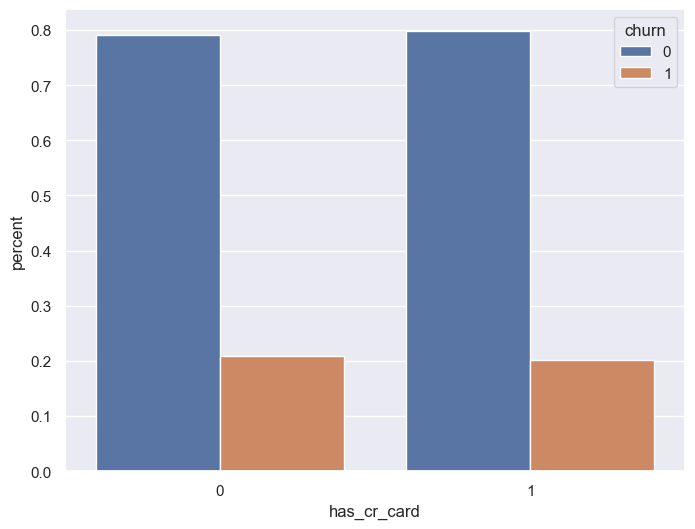

In [21]:
sns.set(rc={'figure.figsize':(8,6)})
g1 = df2.groupby('has_cr_card')['churn'].value_counts(normalize=True).rename('percent').reset_index()
sns.barplot(data=g1, y='percent', x='has_cr_card', hue='churn');

In [22]:
g1

,has_cr_card,churn,percent
0,0,0,0.792
1,0,1,0.208
2,1,0,0.798
3,1,1,0.202


Based on the above graph, we can conclude that whether a customer has a credit card or not is not a determining factor for churn. It is important to note that when conducting such analyses, it is crucial to compare the proportions to avoid bias due to higher frequency in certain classes.

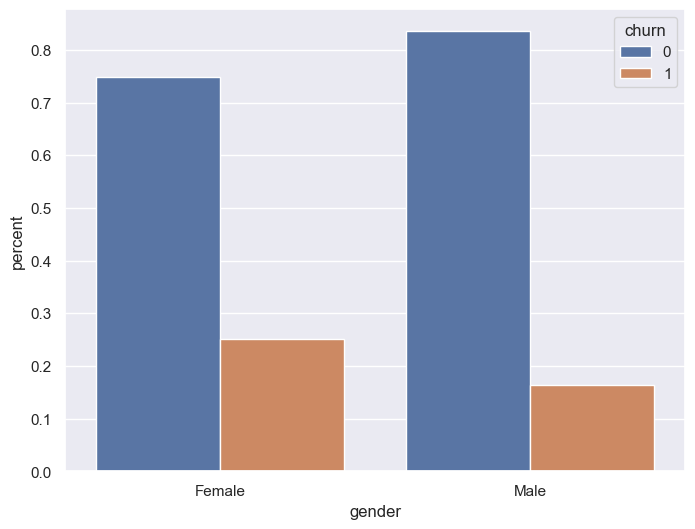

In [23]:
g2 = df2.groupby('gender')['churn'].value_counts(normalize=True).rename('percent').reset_index()
sns.barplot(data=g2, y='percent', x='gender', hue='churn');

In [24]:
g2

,gender,churn,percent
0,Female,0,0.749
1,Female,1,0.251
2,Male,0,0.835
3,Male,1,0.165


Carrying out an analysis similar to the previous one, now considering the 'gender' variable, we see that the proportion of churns is higher for females (25.1%) when compared to males (16.5%).

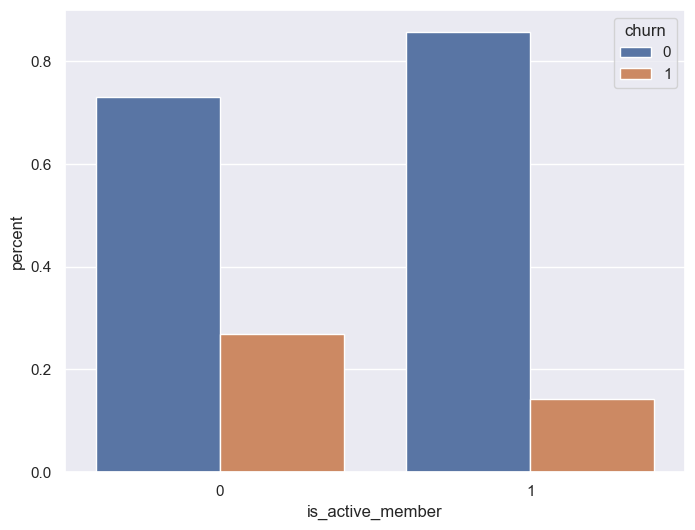

In [25]:
g3 = df2.groupby('is_active_member')['churn'].value_counts(normalize=True).rename('percent').reset_index()
sns.barplot(data=g3, y='percent', x='is_active_member', hue='churn');

In [26]:
g3

,is_active_member,churn,percent
0,0,0,0.731
1,0,1,0.269
2,1,0,0.857
3,1,1,0.143


As expected, active members tend not to be churns while non-active tend to be.

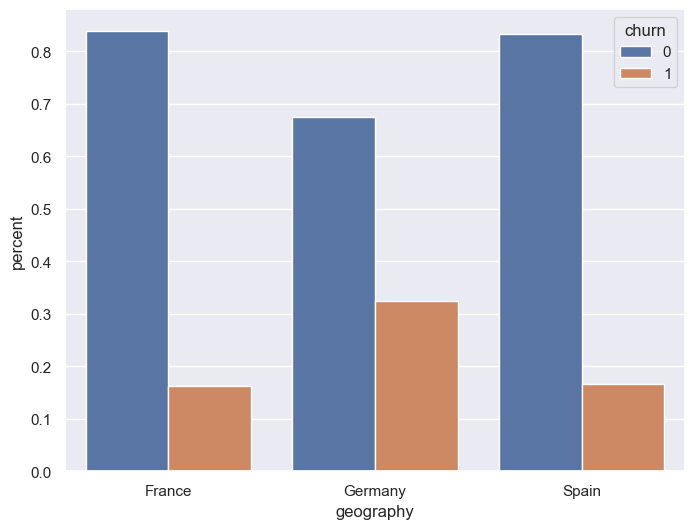

In [27]:
g4 = df2.groupby('geography')['churn'].value_counts(normalize=True).rename('percent').reset_index()
sns.barplot(data=g4, y='percent', x='geography', hue='churn');

In [28]:
g4

,geography,churn,percent
0,France,0,0.838
1,France,1,0.162
2,Germany,0,0.676
3,Germany,1,0.324
4,Spain,0,0.833
5,Spain,1,0.167


When examining the data, Germany is the country with the highest proportion of customers who have churned (32.4%). Spain has similar proportions to France (around 16%).

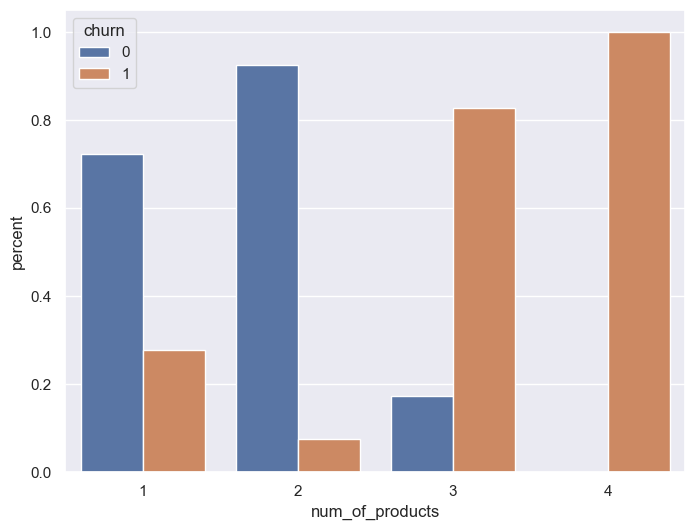

In [29]:
g5 = df2.groupby('num_of_products')['churn'].value_counts(normalize=True).rename('percent').reset_index()
sns.barplot(data=g5, y='percent', x='num_of_products', hue='churn');

In [30]:
df2.groupby('num_of_products')['churn'].value_counts().to_frame()

churn
num_of_products churn       
1               0       3675
                1       1409
2               0       4242
                1        348
3               1        220
                0         46
4               1         60

Based on the analysis of the number of services/products that customers have at the bank, it is evident that the proportion of churns is higher for customers who have more than two services. It can generate the insight that having more services can lead to higher interest rates, exposing more dissatisfaction with a specific service, among other factors that end up causing this customer to churn.

However, it is important to note that the sample of customer classes that have more than 2 services is very small compared to the others. Let's consider that the data were collected in order to guarantee good representation of the user population of the bank.


## Densities


In [31]:
# columns 
print(df2.columns)

df2 = df2.drop('customer_id',axis=1).copy()

Index(['customer_id', 'credit_score', 'geography', 'gender', 'age', 'tenure',
       'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'churn'],
      dtype='object')


In [32]:
summary(data)

,Min,Max,Range,Mean,Median,Standard Deviation,Skewness,Kurtosis
customer_id,15565701.000,15815690.000,249989.000,15690940.569,15690738.000,71932.589,0.001,-1.196
credit_score,350.000,850.000,500.000,650.529,652.000,96.648,-0.072,-0.426
age,18.000,92.000,74.000,38.922,37.000,10.487,1.011,1.395
tenure,0.000,10.000,10.000,5.013,5.000,2.892,0.011,-1.165
balance,0.000,250898.090,250898.090,76485.889,97198.540,62394.285,-0.141,-1.489
num_of_products,1.000,4.000,3.000,1.530,1.000,0.582,0.746,0.583
has_cr_card,0.000,1.000,1.000,0.706,1.000,0.456,-0.902,-1.187
is_active_member,0.000,1.000,1.000,0.515,1.000,0.500,-0.060,-1.997
estimated_salary,11.580,199992.480,199980.900,100090.240,100193.915,57507.617,0.002,-1.182
churn,0.000,1.000,1.000,0.204,0.000,0.403,1.472,0.166


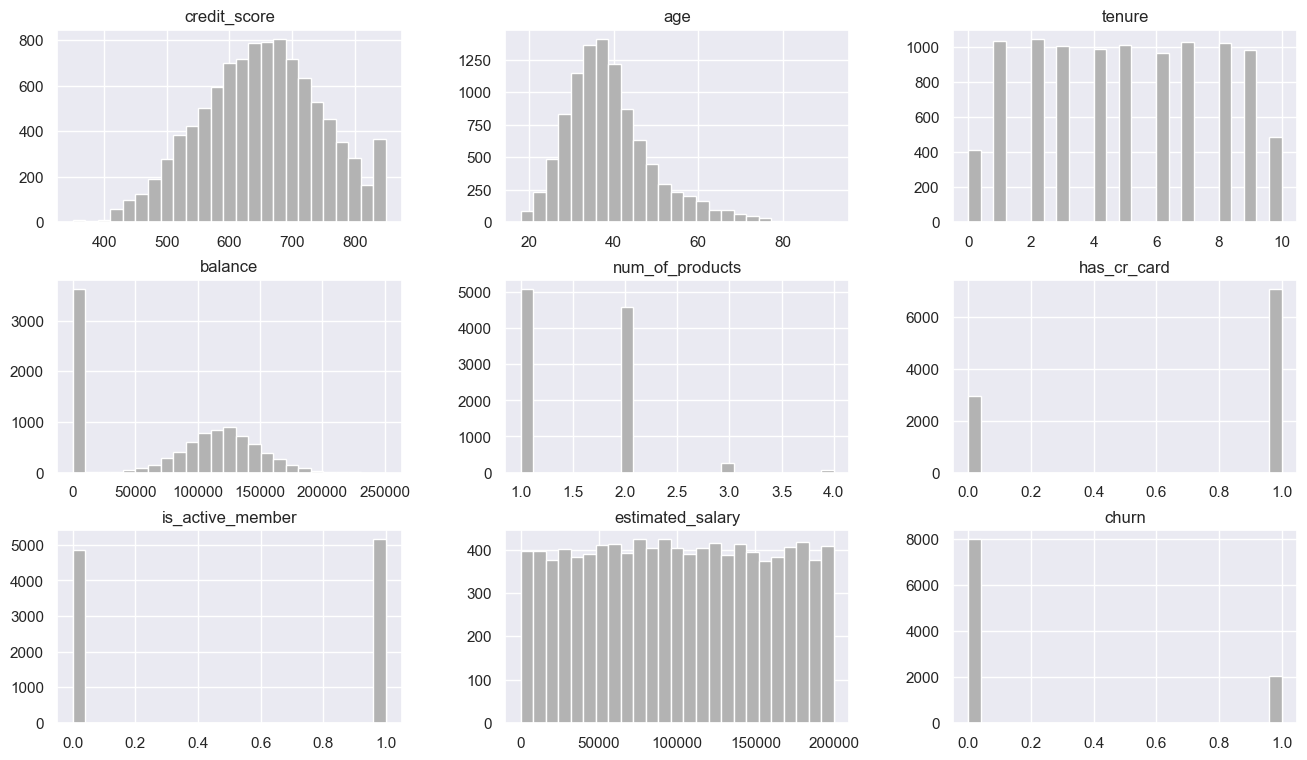

In [33]:
sns.set(rc={'figure.figsize':(16,9)})
df2.select_dtypes(include=['int64','float64']).hist(bins=25, color='0.7');

Observing the density of the data provides us with information about how the values of the variables are distributed, if there are outliers, if the centrality measure is being well representative, if there are specific patterns.

For the dataset in question, we can observe that for the variable 'age' the values are concentrated around 38 years with a decay for the more advanced years, giving the characteristic of skewness on the right. 

The 'estimated_salary' variable shows a constant pattern for all observed values, while the 'balance' variable has a density of well-distributed values around an average. The 'credit_score' variable shows that most customers have credit scores around 650 points. For class variables, such as numbers of products\services that the customer has, it is possible to observe the dispersion of values for each one of them.


## Correlations

In [34]:
df2.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


#### Pearson

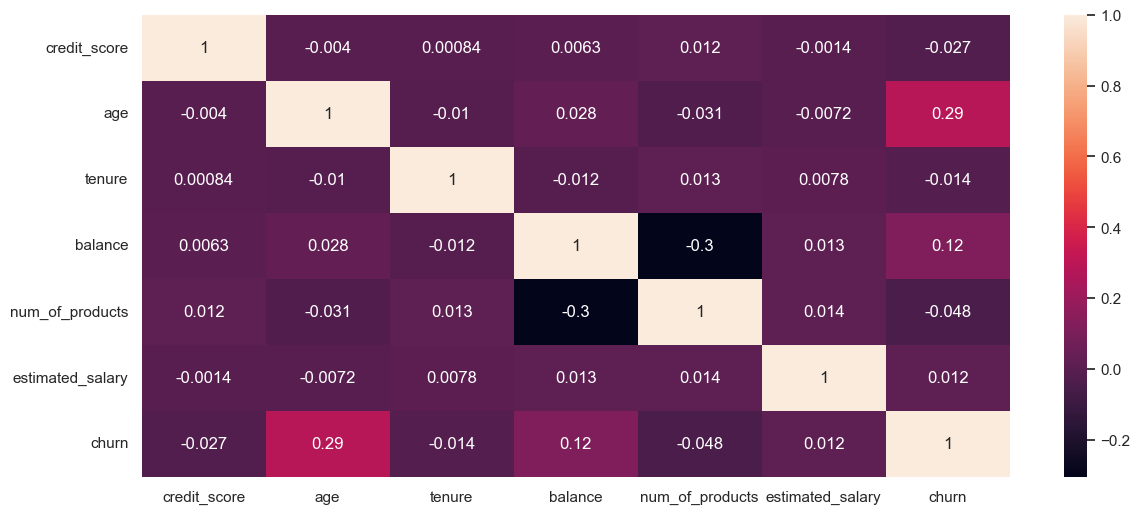

In [35]:
sns.set(rc={'figure.figsize':(14,6)})
aux = df2[['credit_score','age','tenure','balance','num_of_products','estimated_salary','churn']]
corr = aux.corr(method='pearson')

sns.heatmap(corr,annot=True);

With the confusion matrix of Pearson's correlations, we can observe that the variables that are most associated with Churn are 'age' and 'balance', both with positive correlation indicating that the number grows according to the growth of the values of these variables.


Another association that draws attention is the number of products with a balance sheet, which is the strongest correlation in the entire matrix (-30%). It is a negative correlation indicating that customers with higher balance values have fewer bank products/services. Another conclusion based on the data is that customers who have more products/services from the bank are those with less balance values, which may be a plausible explanation of why customers with a greater number of services tend to be Churns.

It is worth noting that Pearson's correlation is symmetric, in which case it may not be representative in cases where the relationship between two variables is not symmetric. In this case, it is worth using the Predictive Power Score (PPS).

#### Cramer's V

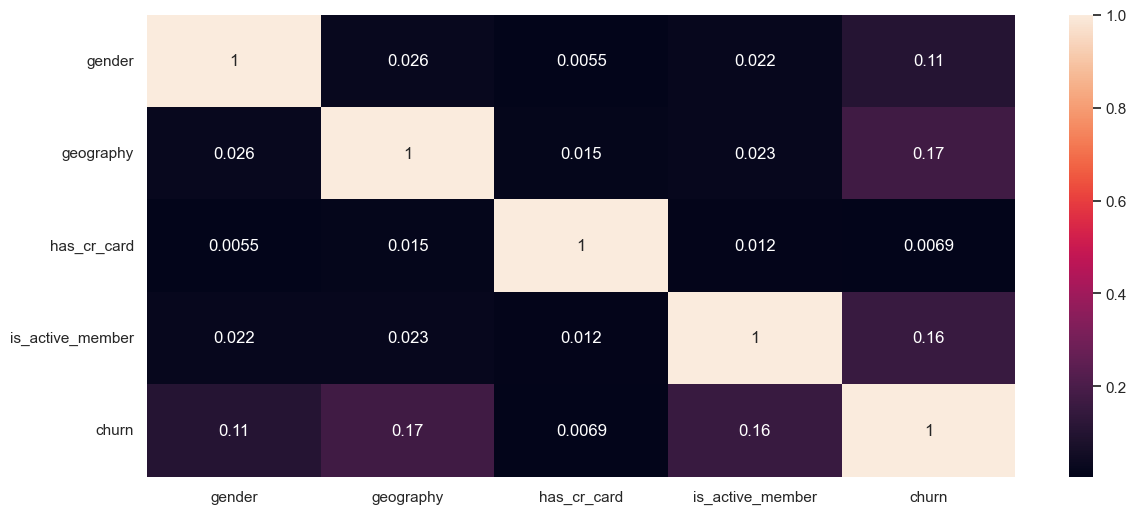

In [36]:
a1= cramer_v( df2['gender'], df2['gender'] )
a2 = cramer_v( df2['gender'], df2['geography'] )
a3 = cramer_v( df2['gender'], df2['has_cr_card'] )
a4 = cramer_v( df2['gender'], df2['is_active_member'] )
a5 = cramer_v( df2['gender'], df2['churn'] )

a6 = cramer_v( df2['geography'], df2['gender'] )
a7 = cramer_v( df2['geography'], df2['geography'] )
a8 = cramer_v( df2['geography'], df2['has_cr_card'] )
a9 = cramer_v( df2['geography'], df2['is_active_member'] )
a10 = cramer_v( df2['geography'], df2['churn'] )

a11 = cramer_v( df2['has_cr_card'], df2['gender'] )
a12 = cramer_v( df2['has_cr_card'], df2['geography'] )
a13 = cramer_v( df2['has_cr_card'], df2['has_cr_card'] )
a14 = cramer_v( df2['has_cr_card'], df2['is_active_member'] )
a15 = cramer_v( df2['has_cr_card'], df2['churn'] )

a16 = cramer_v( df2['is_active_member'], df2['gender'] )
a17 = cramer_v( df2['is_active_member'], df2['geography'] )
a18 = cramer_v( df2['is_active_member'], df2['has_cr_card'] )
a19 = cramer_v( df2['is_active_member'], df2['is_active_member'] )
a20 = cramer_v( df2['is_active_member'], df2['churn'] )

a21 = cramer_v( df2['churn'], df2['gender'] )
a22 = cramer_v( df2['churn'], df2['geography'] )
a23 = cramer_v( df2['churn'], df2['has_cr_card'] )
a24 = cramer_v( df2['churn'], df2['is_active_member'] )
a25 = cramer_v( df2['churn'], df2['churn'] )

# Findf2l ddf2tdf2set
d = pd.DataFrame( {'gender': [a1, a2, a3,a4,a5],'geography': [a6,a7,a8,a9,a10],'has_cr_card': [a11,a12,a13,a14,a15],'is_active_member': [a16,a17,a18,a19,a20],'churn': [a21,a22,a23,a24,a25] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );


With Cramer's V, we can observe which categorical variables are associated with each other. As the measure returns a value between 0 and 1, with 0 being non-association and 1 being perfect association, we see that the variables are not very correlated with Churn, especially the variable 'has_cr_card' which presents a correlation of 0.69%, which converges with the analysis performed earlier.
    

### Some cool ways to visualize EDA in a practical way.

In [37]:
# from pandas_profiling import ProfileReport
# ProfileReport(df2)

# import sweetviz as sv
# sv.analyze(df2).show_html()

# 3.0 Feature Engineering

In [38]:
df3 = df2.copy()
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [39]:
#Tenure by age
df3['tenure_by_age'] = df3['tenure']/df3['age']
df3.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn,tenure_by_age
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1,0.048
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,0.024


It is expected to find a strong correlation between existing and newly created variables when the latter are based on the former. Which may be, in a way, unnecessary since the model would be receiving variables 'that explain the same thing'. However, this new variable can point to a specific trend for the model that can only be observed when associating these other variables that gave rise to it.

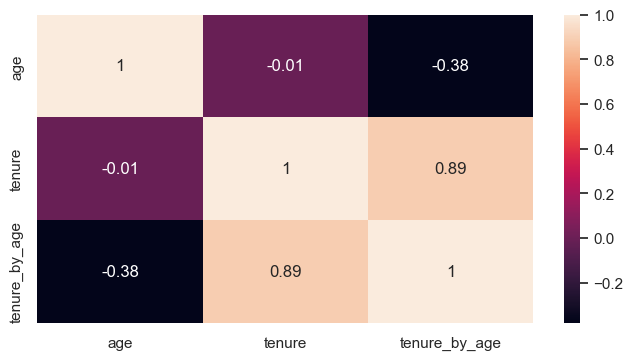

In [40]:
sns.set(rc={'figure.figsize':(8,4)})
corr = df3[['age','tenure','tenure_by_age']].corr(method='pearson')
sns.heatmap(corr, annot=True);

In [41]:
#binning age
df3['age_binned'] = pd.qcut(df3['age'], q=8, labels=[1,2,3,4,5,6,7,8]).astype('int64')
df3.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn,tenure_by_age,age_binned
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1,0.048,6
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,0.024,6


By binarizing the age variable, you now have customers divided into age groups, which can make it easier for the model to identify patterns in these customers given the groups

## 3.1 Encoding

In [42]:
#One hot encoding
df3['gender'] = df3['gender'].apply(lambda x: 1 if x =='Male' else 0)

df3 = pd.get_dummies(df3)
df3.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn,tenure_by_age,age_binned,geography_France,geography_Germany,geography_Spain
0,619,0,42,2,0.000,1,1,1,101348.880,1,0.048,6,1,0,0
1,608,0,41,1,83807.860,1,0,1,112542.580,0,0.024,6,0,0,1
2,502,0,42,8,159660.800,3,1,0,113931.570,1,0.190,6,1,0,0
3,699,0,39,1,0.000,2,0,0,93826.630,0,0.026,5,1,0,0
4,850,0,43,2,125510.820,1,1,1,79084.100,0,0.047,6,0,0,1


One hot encoding causes categorical variables to be represented with values 0 or 1.

## 3.2 Rescaling



In [43]:
#MinMax Scaler
scaler = MinMaxScaler()
df3['balance'] = scaler.fit_transform(df3[['balance']].values)
df3['estimated_salary'] = scaler.fit_transform(df3[['estimated_salary']].values)
df3['credit_score'] = scaler.fit_transform(df3[['credit_score']].values)
df3['age'] = scaler.fit_transform(df3[['age']].values)
df3['tenure'] = scaler.fit_transform(df3[['tenure']].values)


In this step, where we adjust the data scale, there are some methods that help us. The Standard Scaler and MinMax Scaler are the two most popular, where the first is based on leaving the values with mean 0 and standard deviation 1 and the second divides its values by the amplitude of the variable. As our dataset does not have values that are very different from the others, we use the MinMax Scaler.


# 4.0 Hyphotesis

In [44]:
df4 = df3.copy()

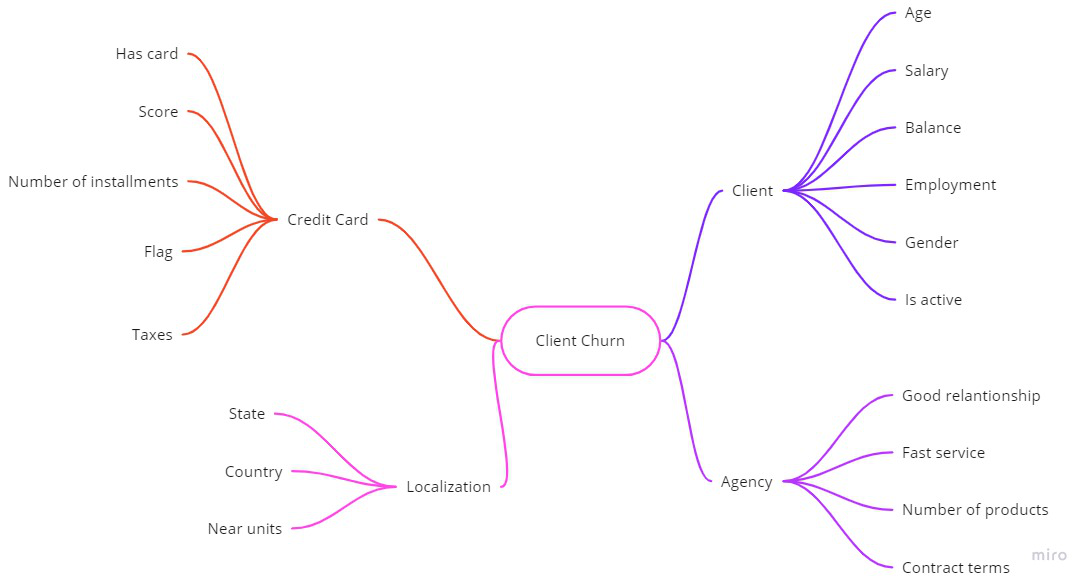

In [45]:
Image.open('mindmap.jpg')

This mind map is interesting to help create hypotheses

## H1: The older the age, the greater the number of churn
**TRUE - As the customer is older, the churn rate increases**

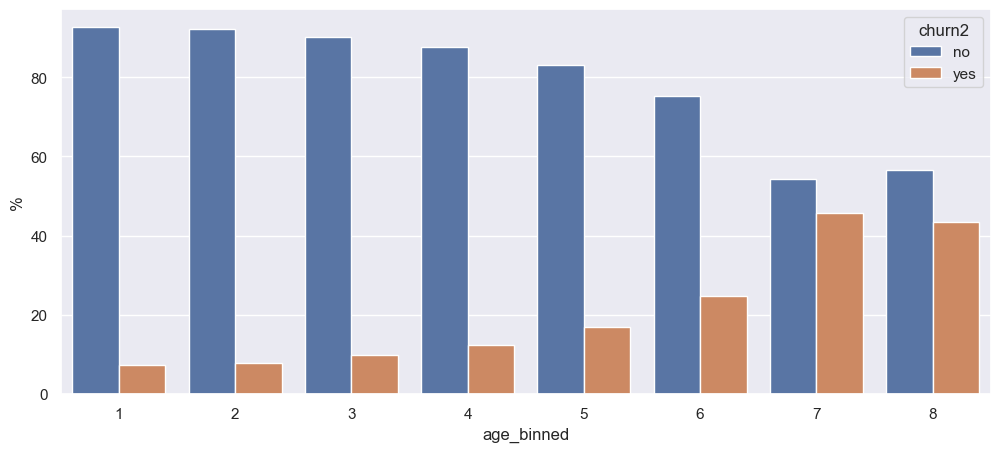

In [46]:
sns.set(rc={'figure.figsize':(12,5)})

df4['churn2'] = df4['churn'].apply(lambda x: 'yes' if x==1 else 'no')

h1 = df4[['age_binned','churn2', 'churn']].groupby(['churn2', 'age_binned']).count().reset_index()
h1['%'] = 100 * h1['churn'] / h1.groupby('age_binned')['churn'].transform('sum')

sns.barplot(data=h1, y='%', x='age_binned', hue='churn2');


The first hypothesis was based on previous insights where the number of churns was higher in older customers. We can conclude that churn ratios actually increase as age ranges increase.

## H2: Churn rate increases with tenure
**False - The churn rate is constantly with tenure**

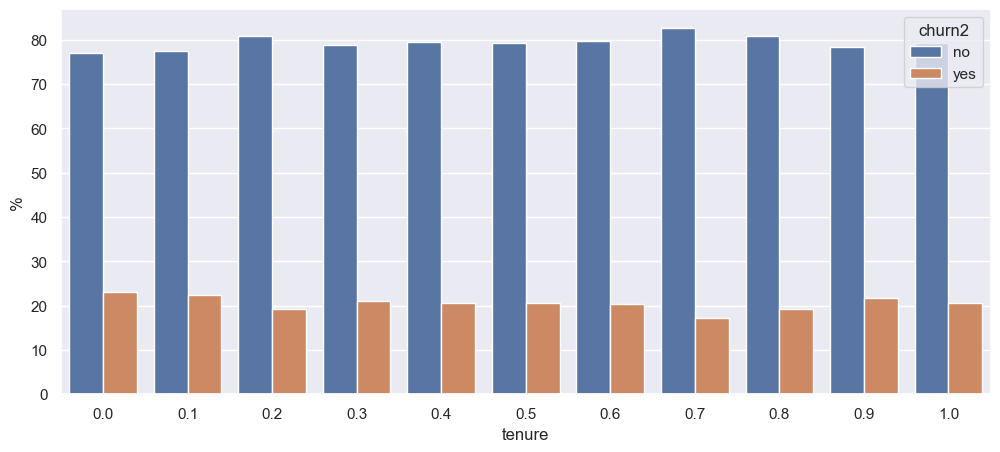

In [47]:
sns.set(rc={'figure.figsize':(12,5)})

h2 = round(df4[['tenure','churn2', 'churn']],2).groupby(['churn2', 'tenure']).count().reset_index()
h2['%'] = 100 * h2['churn'] / h2.groupby('tenure')['churn'].transform('sum')

sns.barplot(data=h2, y='%', x='tenure', hue='churn2');

The second hypothesis considers that the churn rate increases with the time that the individual is a Bank customer. We can see that the churn ratios are constant for all groups, from newer customers to older ones.

## H3: Being active member decrease churn rate
**TRUE - The churn rate decreases 12% if the client is active**

,churn2,is_active_member,churn,%
0,no,0,3547,73.149
1,no,1,4416,85.731
2,yes,0,1302,26.851
3,yes,1,735,14.269


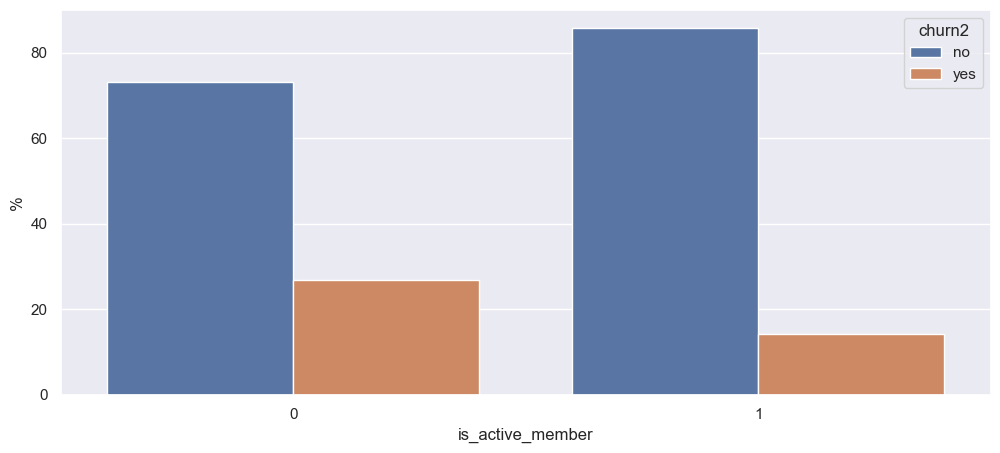

In [48]:
h3 = df4[['is_active_member','churn2', 'churn']].groupby(['churn2', 'is_active_member']).count().reset_index()
h3['%'] = 100 * h3['churn'] / h3.groupby('is_active_member')['churn'].transform('sum')

sns.barplot(data=h3, y='%', x='is_active_member', hue='churn2')
h3

This is a hypothesis that had already been validated. The proportion of churns is actually lower for active customers

## H4: Clients who have more money are more likely to churn
**TRUE - The churn rate increases the way the balance increases**

In [49]:
df4['balance_binned'] = pd.qcut(df4['balance'].rank(method='first'), q=10, labels=[1,2,3,4,5,6,7,8,9,10]).astype('int64')

,churn2,balance_binned,churn,%
10,yes,1,151,15.100
11,yes,2,146,14.600
12,yes,3,127,12.700
13,yes,4,166,16.600
14,yes,5,198,19.800
15,yes,6,248,24.800
16,yes,7,284,28.400
17,yes,8,255,25.500
18,yes,9,234,23.400
19,yes,10,228,22.800


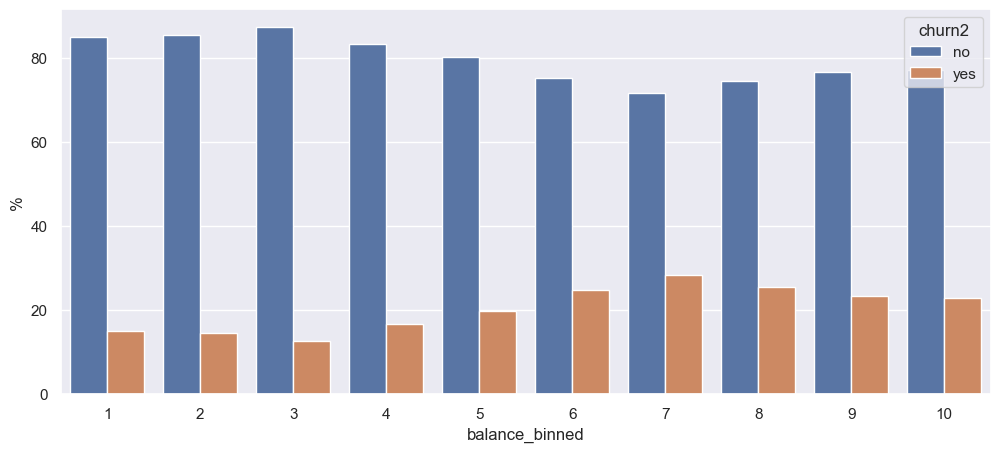

In [50]:
h4 = df4[['balance_binned','churn2', 'churn']].groupby(['churn2', 'balance_binned']).count().reset_index()
h4['%'] = 100 * h4['churn'] / h4.groupby('balance_binned')['churn'].transform('sum')

sns.barplot(data=h4, y='%', x='balance_binned', hue='churn2');
h4[h4['churn2'] == 'yes']

We can see that the proportions are greater as the balance values increase.

## H5: Clients who have credit card are less likely to churn
**FALSE - The churn rate is constantly by credit card condition**

,churn2,has_cr_card,churn,%
0,no,0,2332,79.185
1,no,1,5631,79.816
2,yes,0,613,20.815
3,yes,1,1424,20.184


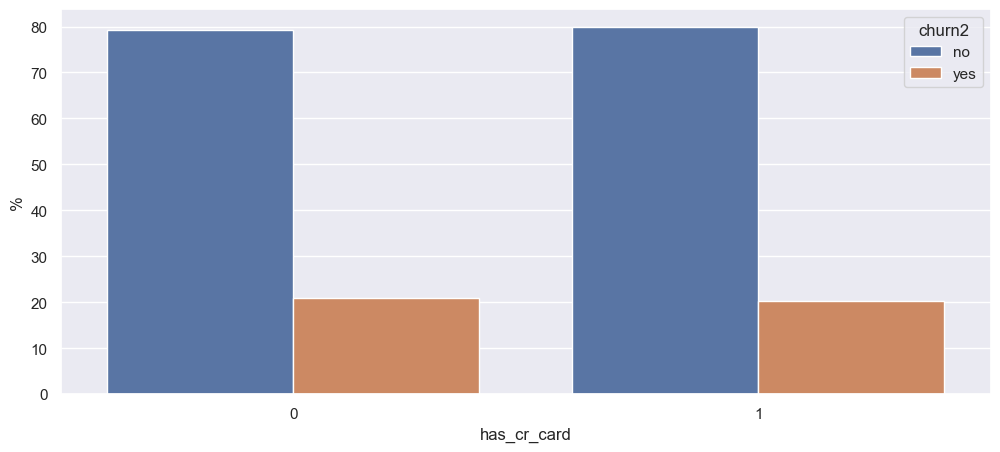

In [51]:
h5 = df4[['has_cr_card','churn2', 'churn']].groupby(['churn2', 'has_cr_card']).count().reset_index()
h5['%'] = 100 * h5['churn'] / h5.groupby('has_cr_card')['churn'].transform('sum')

sns.barplot(data=h5, y='%', x='has_cr_card', hue='churn2');
h5

This hypothesis was also previously validated, where actually having or not a credit card does not prove to be a determinant variable for Churn.


# 5.0 Split Train and Test

In [52]:
df5 = df4.copy()
df5.head(2)

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,churn,tenure_by_age,age_binned,geography_France,geography_Germany,geography_Spain,churn2,balance_binned
0,0.538,0,0.324,0.200,0.000,1,1,1,0.507,1,0.048,6,1,0,0,yes,1
1,0.516,0,0.311,0.100,0.334,1,0,1,0.563,0,0.024,6,0,0,1,no,5


In [53]:
X = df5.drop(['churn','churn2'], axis=1)

In [54]:
y = df5['churn']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

For the machine learning process, it is important to define the set (Training Set) where the model will learn about the characteristics that explain well the objectified event. To measure the degree of learning, the test set is used. It is common to come across some cases where the training, validation and test set is given, where the model evaluation process is taken by training and validation and later applied to the test set. In the case of this project, we will do the split in just 2 sets in an 80% training and 20% test ratio.

## 5.1 Feature importance


An effective way to work with modeling is to define a set of variables that explain our target variable well and disregard variables with a low degree of explanation. This makes the model more parsimonious.

The variables will be chosen through selection by importance given by tree algorithms, by the coefficient value of a logistic regression model (which tells us the incremental or decremental impact on the target variable) and by the Boruta algorithm.


### 5.1.1 Decision tree

In [56]:
# Random Forest - Gini Impurity
model  = RandomForestClassifier(random_state=22, criterion='gini')
model.fit(X_train, y_train)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 


#show importances
pd.DataFrame([list(feats.keys()),list(feats.values())]).T.sort_values(1) \
                                                .rename(columns={0:'Variable',1:'Gini'}).reset_index(drop=True)


,Variable,Gini
0,geography_Spain,0.010
1,geography_France,0.011
2,has_cr_card,0.018
3,gender,0.019
4,geography_Germany,0.021
5,is_active_member,0.044
6,tenure,0.054
7,balance_binned,0.057
8,age_binned,0.090
9,tenure_by_age,0.092


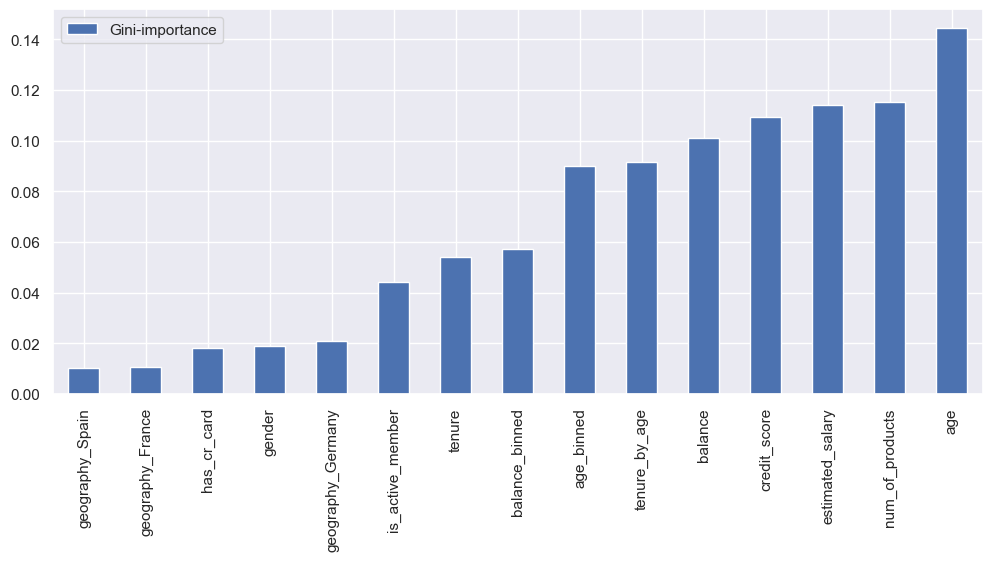

In [57]:
#plot
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar');

In [58]:
cols_r_forest = ['age', 'num_of_products','estimated_salary','credit_score', 'balance']

The values of the Gini and Entropy measures are low for a given variable when it has a high probability for a given class or value. In other words, for a tree algorithm, the higher the entropy or Gini value, we have that this variable will generate more nodes, which in turn can have more information about the class being said by the other variables.

### 5.1.2 Model Coefficients

In [59]:
# define the model
model = LogisticRegression()

# fit the model
model.fit(X_train, y_train)

# get importance
importance = model.coef_[0]

# summarize feature importance
logistic_coeffs = pd.DataFrame(list(enumerate(importance)),index = model.feature_names_in_.tolist())\
                                        .drop(0,axis=1).rename(columns={1:'Coeff'}).sort_values(by='Coeff')
logistic_coeffs

,Coeff
age,-1.614
is_active_member,-0.953
geography_Spain,-0.584
geography_France,-0.554
gender,-0.458
tenure,-0.414
credit_score,-0.327
balance_binned,-0.080
has_cr_card,-0.066
num_of_products,-0.064


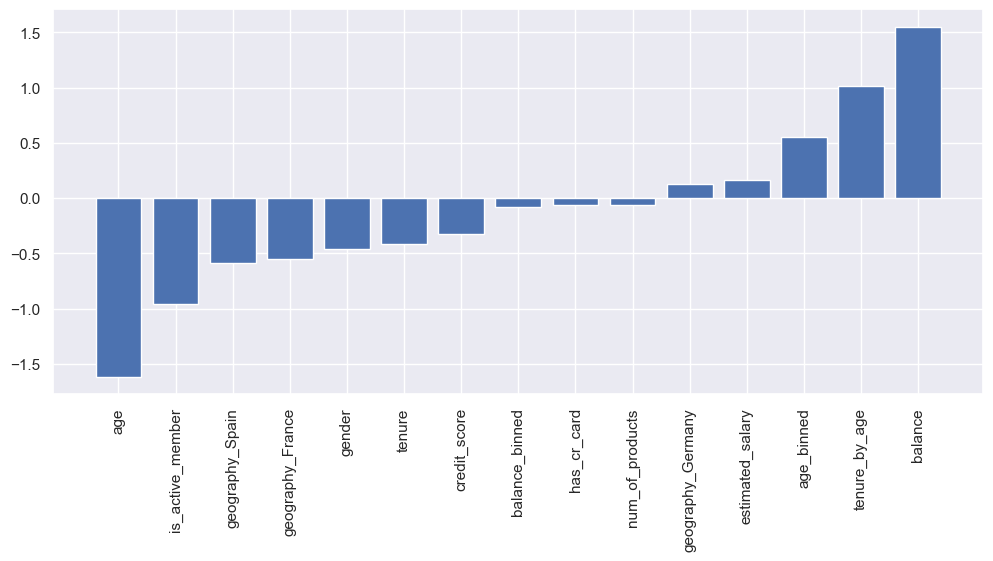

In [60]:
# plot feature importance
height = logistic_coeffs['Coeff']
bars = logistic_coeffs.index.tolist()
y_pos = np.arange(len(bars))

# Barplot
plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation='vertical')
plt.show()

In [61]:
cols_logistic = ['age', 'is_active_member','balance','tenure_by_age']

In statistics, it is common to select a variable based on test statistics, which are based on the coefficient value of the model. The coefficients say the incremental value that the explanatory variable gives to the response variable. The higher these values
(whether positive or negative) the more relationship the explanatory variable has with the response variable.

### Boruta Selector

In [ ]:
import pandas as pd
from boruta import BorutaPy

rf = RandomForestClassifier(random_state=22)

X_train_n = X_train.values
y_train_n = y_train.values.ravel()

boruta =BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [65]:
cols_selected = boruta.support_.tolist()
# best features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
# not_selected_boruta 
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

The Boruta algorithm can be summarized in creating copies of our features and performing statistical tests to compare whether our feature is being as meaningful to the model as the general set of features.

### Selection

In [72]:
print(f'Cols selected by Random Forest: {cols_r_forest}')
print(f'Cols selected by Logistic Model: {cols_logistic}')
print(f'Cols selected by Boruta: {cols_selected_boruta}')

Cols selected by Random Forest: ['age', 'num_of_products', 'estimated_salary', 'credit_score', 'balance']
Cols selected by Logistic Model: ['age', 'is_active_member', 'balance', 'tenure_by_age']
Cols selected by Boruta: ['age', 'balance', 'num_of_products', 'estimated_salary', 'age_binned']


In [62]:
features_list = ['age','num_of_products','estimated_salary','balance']

Of the 3 methods used, the features selected in at least two of these were assumed.

# 6.0 Machine Learning Models

In [63]:
df6 = df5.copy()

## 6.1 Models and Cross-Validation

In [119]:
models = [('Logistic Regression', LogisticRegression(random_state=22)),
          ('K-Nearest Neighbors (KNN)', KNeighborsClassifier()),
          ('Descision Tree (CART)', DecisionTreeClassifier(random_state=22)),
          ('Random Forest', RandomForestClassifier(random_state=22)),
          ('Support Vector Machines (SVM)', SVC(gamma='auto',random_state=22)),
          ('Extreme Gradient Boosting (XGB)', GradientBoostingClassifier(random_state = 22)),
          ("Light Gradient Boosting Machines (LightGBM)", LGBMClassifier(random_state=22))]
results = []
names = []
for name, model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = f'{name} -> CV mean = {round(cv_results.mean(),3)}, CV std = {round(cv_results.std(),2)}, ROC AUC = {round(roc_auc_score(y_test,y_pred)*100,3)}%'
    print(msg)    

Logistic Regression -> CV mean = 0.823, CV std = 0.01, ROC AUC = 61.792%
K-Nearest Neighbors (KNN) -> CV mean = 0.839, CV std = 0.01, ROC AUC = 67.17%
Descision Tree (CART) -> CV mean = 0.789, CV std = 0.02, ROC AUC = 68.669%
Random Forest -> CV mean = 0.863, CV std = 0.01, ROC AUC = 69.24%
Support Vector Machines (SVM) -> CV mean = 0.852, CV std = 0.01, ROC AUC = 64.47%
Extreme Gradient Boosting (XGB) -> CV mean = 0.863, CV std = 0.01, ROC AUC = 69.841%
Light Gradient Boosting Machines (LightGBM) -> CV mean = 0.862, CV std = 0.01, ROC AUC = 69.658%


A more synthesized way to select a candidate model is to initially train several models and analyze some initial metrics. The one that presents the best results can be chosen for the tuning stage.

At this first moment, cross-validation is performed and the average and standard deviation of the accuracy of these created folds is returned.

It is interesting to choose the model with the best values in the metrics and taking into account the parsimony of the model.

### 6.2 Light GBM Classifier

The Random Forest and LightGBM models returned very close metric values, but the Light GBM was chosen for his thrifty trait

In [64]:
model = LGBMClassifier(random_state=22)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

ROC AUC: 69.66 %


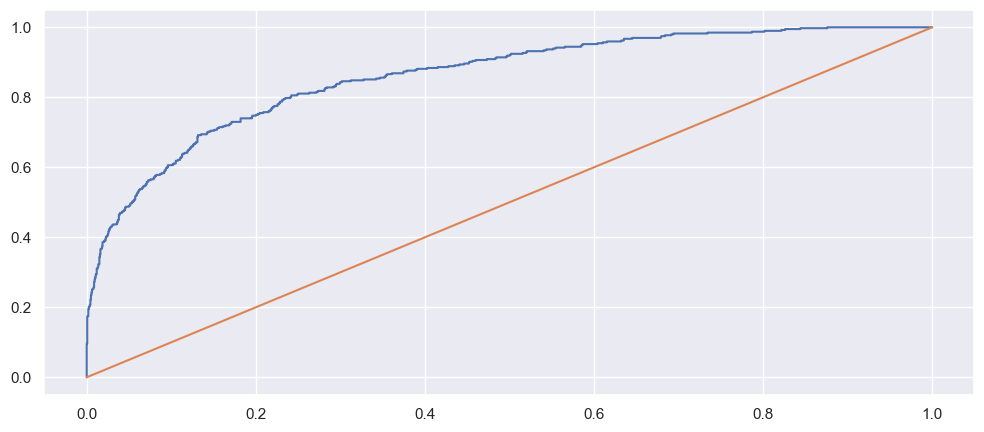

In [76]:
print('ROC AUC: %.2f' % (roc_auc_score(y_test,y_pred)*100), '%')

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test,y_probs)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1]);

The ROC tells us the relationship that the model has in classifying True Positives and False Positives. Visually, we can look at the graph and get the idea that the model would be able to classify correctly 80% of the time when it says that a customer has the Churn profile and would fail 23% of the time when performing this classification.

The area under the curve (AUC) can be thought of as the probability that the model ranks a random positive example higher than a random negative example. The higher the value, the more likely it is to sort correctly versus incorrectly.

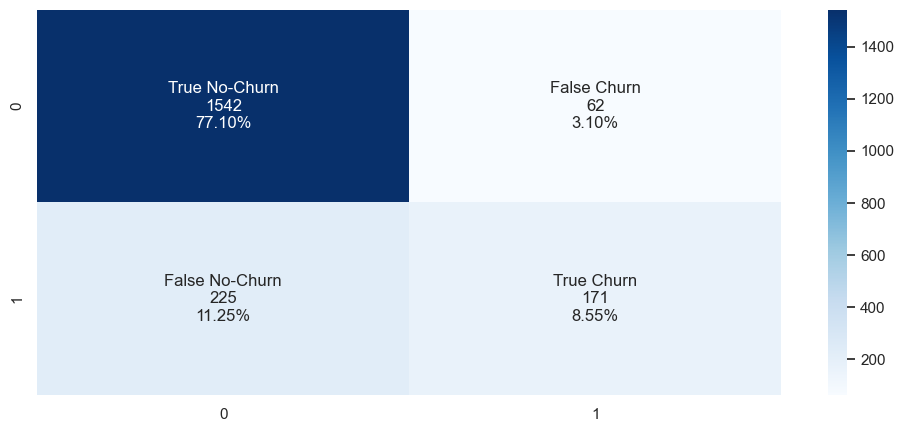

In [79]:
cm_plot(y_test,y_pred)

The confusion matrix is very intuitive, it shows us how well the model can classify.

An efficient way of summarizing the results is, of the predictions made by the classifier, 85.65% were correct (77.10% + 8.55%) against 14.35% incorrect (11.25% + 3.10%)

### 6.3 Tuning

In this step, we will perform a grid search on the model parameters in search of a configuration that will give us the best results. This step is strongly influenced by the computational power available, the more combinations we can perform, the more machine effort we require and the more chances we have of obtaining an efficient model.

In [ ]:
params = {'n_estimators':[12,24,100,128,512],
          'max_depth':[None,4,8,16],
          'num_leaves':[8,16,24],
          'class_weight':[None,'balanced'],
          'random_state': [42]
        }

model = LGBMClassifier()

grid_search = GridSearchCV(estimator = model, param_grid = params, 
                        cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

In [66]:
best_grid = grid_search.best_estimator_
best_grid

In [67]:
model = best_grid

model.fit(X_train,y_train)
ypred = model.predict(X_test)

ROC AUC: 70.13 %


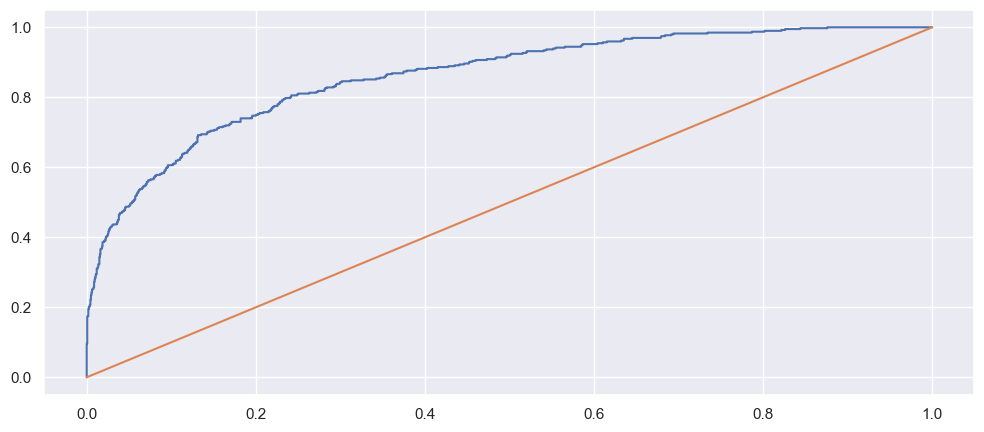

In [68]:
print('ROC AUC: %.2f' % (roc_auc_score(y_test,ypred)*100), '%')

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test,y_probs)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1]);

After tuning, there is a very subtle improvement in the value of the area under the ROC curve, less than 0.5%

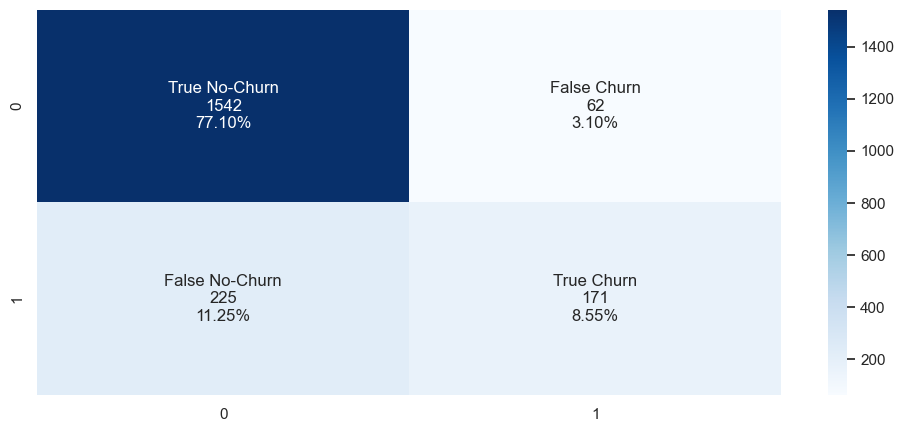

In [93]:
cm_plot(y_test,y_pred)

The confusion matrix indicates that there was no improvement in the tuning of the model.

In [70]:
accuracy_score(y_test, y_pred)

0.8565

The model's accuracy is around 86%, indicating that for every 100 customers, on average, 86 of these will be classified correctly.

We can ask ourselves the following: is it more important for the bank to classify Churns or non-Churns customers well?

By correctly classifying the Churn, the bank is able to take measures to retain that customer, if the Churn is classified incorrectly, the bank will have assumed these measures for the customer who was not going to leave the bank. But note that this error is less evil than the error of classifying a customer as Not Churn and actually being. So we are talking about Type I error and Type II error.

Let's then look at the scores for each class individually.

In [100]:
print(classification_report(y_test, y_pred, target_names=['No-Churn','Churn']))

              precision    recall  f1-score   support

    No-Churn       0.87      0.96      0.91      1604
       Churn       0.73      0.43      0.54       396

    accuracy                           0.86      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.85      0.86      0.84      2000



Precision: Of all the predictions the model makes for a given class, how many are correct?
 - No-Churn Precision: 87% - Indicates that of the individuals the model predicts to be No-Churn, 13% of the time is incorrect. 

 - Churn Precision: 73% - Indicates that of the individuals the model predicts to be Churn, 27% of the time is incorrect

 Recall: Of all the customers that are in fact of a certain class, how many did the model get right?
  - No-Churn Recall: 96% - The model was able to predict 96% of No-Churns 

  - Churn Recall: 43% - The model was not able to predict 67% of Churns.

# Conclusions

With the results obtained, it is clear that for a classification project it is not enough to just evaluate model performance metrics in general, if we were based on the accuracy value we would make the decision that the model performed well because an accuracy value of 86% indicates that it is right most of the time.

However, when we looked at the performance for the class individually, we noticed that the model did very well at learning when the customer won't churn. In fact, the non-churn class was so considered in the model that it ended up classifying as No-Churn many that in reality were Churn (false negative - error type II) which is the worst error for the project case. To say that a customer is churn when in fact he is not would be less of a bad thing.

Knowing this, a good decision would be to go back to the preprocessing session and perform data balancing techniques so that both classes are learned in a balanced way by the model and avoiding greater representation for the class with more observations.

Other options would be: Perform feature engineering in search of features that would more effectively explain the target variable; optimize the feature selection technique, consider other models such as the use of neural networks; require a bit more computational effort in the tuning section of the model.

All are valid considerations for applications looking to improve performance. It is important to obtain preliminary results like this one, as this is how we understand the entire flow of the project and are able to guide the next steps. Carrying out the work in a cyclical way, we allow ourselves to approach all stages of the project without going deeper into the sections immediately, which reduces the risk of optimizing a solution that later on would be discarded for some reason not tracked in the initial stages of the project.

